In [1]:
import mxnet as mx
import logging
import numpy as np
import tensorflow as tf   
import mxnet as mx
from mxboard import SummaryWriter
    
# setup logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
# Basic Conv + BN + ReLU factory
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0, 0), act_type="relu"):
    # there is an optional parameter ```wrokshpace``` may influece convolution performance
    # default, the workspace is set to 256(MB)
    # you may set larger value, but convolution layer only requires its needed but not exactly
    # MXNet will handle reuse of workspace without parallelism conflict
    conv = mx.symbol.Convolution(data=data, workspace=256,
                                 num_filter=num_filter, kernel=kernel, stride=stride, pad=pad)
    bn = mx.symbol.BatchNorm(data=conv)
    act = mx.symbol.Activation(data = bn, act_type=act_type)
    return act

In [3]:
# A Simple Downsampling Factory
def DownsampleFactory(data, ch_3x3):
    # conv 3x3
    conv = ConvFactory(data=data, kernel=(3, 3), stride=(2, 2), num_filter=ch_3x3, pad=(1, 1))
    # pool
    pool = mx.symbol.Pooling(data=data, kernel=(3, 3), stride=(2, 2), pad=(1,1), pool_type='max')
    # concat
    concat = mx.symbol.Concat(*[conv, pool])
    return concat

In [4]:
# A Simple module
def SimpleFactory(data, ch_1x1, ch_3x3):
    # 1x1
    conv1x1 = ConvFactory(data=data, kernel=(1, 1), pad=(0, 0), num_filter=ch_1x1)
    # 3x3
    conv3x3 = ConvFactory(data=data, kernel=(3, 3), pad=(1, 1), num_filter=ch_3x3)
    #concat
    concat = mx.symbol.Concat(*[conv1x1, conv3x3])
    return concat

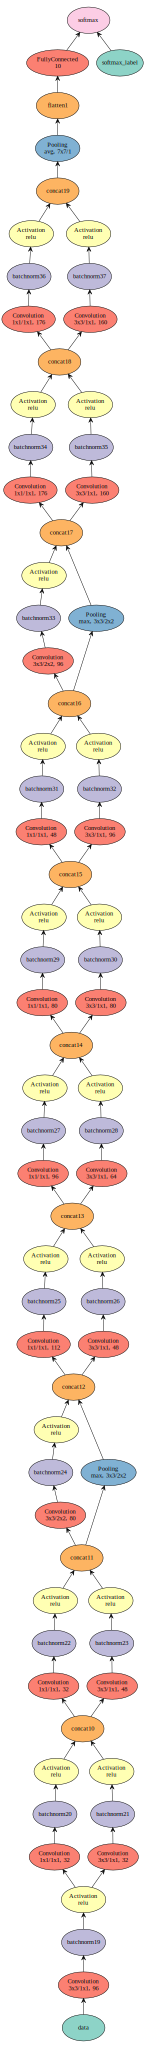

In [9]:
data = mx.symbol.Variable(name="data")
conv1 = ConvFactory(data=data, kernel=(3,3), pad=(1,1), num_filter=96, act_type="relu")
in3a = SimpleFactory(conv1, 32, 32)
in3b = SimpleFactory(in3a, 32, 48)
in3c = DownsampleFactory(in3b, 80)
in4a = SimpleFactory(in3c, 112, 48)
in4b = SimpleFactory(in4a, 96, 64)
in4c = SimpleFactory(in4b, 80, 80)
in4d = SimpleFactory(in4c, 48, 96)
in4e = DownsampleFactory(in4d, 96)
in5a = SimpleFactory(in4e, 176, 160)
in5b = SimpleFactory(in5a, 176, 160)
pool = mx.symbol.Pooling(data=in5b, pool_type="avg", kernel=(7,7), name="global_avg")
flatten = mx.symbol.Flatten(data=pool)
fc = mx.symbol.FullyConnected(data=flatten, num_hidden=10)
softmax = mx.symbol.SoftmaxOutput(name='softmax',data=fc)
mx.viz.plot_network(symbol=softmax,node_attrs={'shape':'oval','fixedsize':'false'})

In [6]:
num_epoch = 1
model = mx.model.FeedForward(ctx=mx.cpu(), symbol=softmax, num_epoch=num_epoch,
                             learning_rate=0.05, momentum=0.9, wd=0.00001)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
batch_size = 128
total_batch = 50000 / 128 + 1
train_dataiter = mx.io.ImageRecordIter(
        shuffle=True,
        path_imgrec="/home/alex/cifar10_train.rec",
        mean_img="/home/alex/cifar_mean.bin",
        rand_crop=True,
        rand_mirror=True,
        data_shape=(3,28,28),
        batch_size=batch_size,
        preprocess_threads=1)
# test iterator make batch of 128 image, and center crop each image into 3x28x28 from original 3x32x32
# Note: We don't need round batch in test because we only test once at one time
test_dataiter = mx.io.ImageRecordIter(
        path_imgrec="/home/alex/cifar10_val.rec",
        mean_img="/home/alex/cifar_mean.bin",
        rand_crop=False,
        rand_mirror=False,
        data_shape=(3,28,28),
        batch_size=batch_size,
        round_batch=False,
        preprocess_threads=1)

In [8]:
train_dataiter.reset()
for data in train_dataiter:
    d = data.data[0]


augs = mx.image.CreateAugmenter(data_shape=(3,28,28), rand_mirror=True, 
                               mean=True, brightness = 0.125, contrast=0.125, rand_gray=0.05, 
                               saturation=0.125, pca_noise=0.05, inter_method=10) # 

In [11]:
augs = mx.image.CreateAugmenter(data_shape=(3,28,28), rand_mirror=True, mean=True, brightness = 0.125, contrast=0.125, rand_gray=0.05, saturation=0.125, pca_noise=0.05, inter_method=10) # а что дальше

In [20]:
class SummaryWriter(object):
    def __init__(self, log_dir):
        self.file_writer = FileWriter(logdir=log_dir)

    def add_scalar(self, name, scalar_value, global_step=None):
        self.file_writer.add_summary(scalar(name, scalar_value), global_step)

    def add_histogram(self, name, values):
        self.file_writer.add_summary(histogram(name, values))

    def add_image(self, tag, img_tensor):
        self.file_writer.add_summary(image(tag, img_tensor))

    def close(self):
        self.file_writer.flush()
        self.file_writer.close()

    def __del__(self):
        if self.file_writer is not None:
            self.file_writer.close()

In [12]:
import logging
class LogMetricsCallback(object):
    def __init__(self, logging_dir, prefix=None):
        self.prefix=prefix
        try:
            from tensorboard import SummaryWriter
            self.summury_writer=SummaryWriter(logging_dir)
        except ImportError:
            logging.error("Neo, you are not elected - go to programm")
        
    def __call__(self, param):
        if param.eval_maetric is None:
            return
        name_value = param.eval_metric.get_name_value()
        for name, value in name_value:
            if self.prefix is not None:
                name = '%s-%s' % (self.prefix, name)
            self.summury_writer.add_scalar(name,value)
    


In [ ]:
training_log = '/home/alex/logs/train'
evaluation_log = '/home/alex/logs/eval'
batch_end_callbacks = [mx.contrib.tensorboard.LogMetricsCallback(training_log)]
eval_end_callbacks = [mx.contrib.tensorboard.LogMetricsCallback(evaluation_log)]
model.fit(X=train_dataiter,
          eval_data=test_dataiter,
          eval_metric="accuracy",
          batch_end_callback=batch_end_callbacks,
         eval_end_callback = eval_end_callbacks) # почему batch_end_callback не определено!?
# batch_end_callback=mx.callback.Speedometer(batch_size)
# eval_end_callback = eval_end_callbacks

ERROR:root:You can install tensorboard via `pip install tensorboard`.
ERROR:root:You can install tensorboard via `pip install tensorboard`.
INFO:root:Start training with [cpu(0)]
